In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from urllib.request import urlopen
import string
import datetime
from dateutil.relativedelta import relativedelta
from tkinter import *
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure

In [123]:
def loaddata(symbol,date):
    #getting the data from Yahoo finance
    sdate = datetime.datetime.strptime("2020-11-13", '%Y-%m-%d')
    edate = datetime.datetime.strptime(date, '%Y-%m-%d')
    delta = edate-sdate
    url = "https://finance.yahoo.com/quote/"+symbol+"/options?date="+str(delta.days*86400+1605225600)
    
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")
    
    return html

In [124]:
def callpayoff(price, strike, premium):
    if price < strike:
        return premium*(-100)
    else:
        return (price-strike)*100 - premium*100
def putpayoff(price, strike, premium):
    if price > strike:
        return premium*(-100)
    else:
        return (strike-price)*100 - premium*100

In [125]:
class Asset:
    def __init__(self,underlying,quantity,ls):
        self.underlying = underlying
        self.quantity = quantity
        self.ls = ls
    def get_underlying(self):
        return self.underlying
    def get_quantity(self):
        return self.quantity
    def get_ls(self):
        return self.ls

In [126]:
class Option(Asset):
    def __init__(self,strike,cp,underlying,quantity,ls,maturity):
        super().__init__(underlying,quantity,ls)
        self.strike = strike
        self.cp = cp
        self.maturity = maturity
    def get_strike(self):
        return self.strike
    def get_cp(self):
        return self.cp
    def get_maturity(self):
        return self.maturity
    def find_price(self,html):
        sdate = datetime.datetime.strptime("2020-11-13", '%Y-%m-%d')
        edate = datetime.datetime.strptime(self.maturity, '%Y-%m-%d')
        delta = edate-sdate
        ender = str(int(self.strike*1000))[::-1]
        i = len(ender)
        while i < 8:
            ender = ender + "0"
            i+=1
        ender = ender[::-1]
        combined = self.underlying+str(edate.year)[-2:]+str(edate.month)+str(edate.day)+self.cp.upper()+ender
        left = html.find(combined)
        right = html.find(combined)+500
        b = "{:.2f}".format(self.strike)+ """</a></td><td class="data-col3 Ta(end) Pstart(7px)" data-reactid="""
        left1 = html[left:right].find(b)+len(b) + left
        c = ">"
        left2 = html[left1:right].find(c) + len(c) + left1
        d = "<"
        right1 = html[left2:right].find(d)+left2

        return float(html[left2:right1])
        
    def get_type(self):
        return "Option"

In [127]:
class Stock(Asset):
    def __init__(self,underlying,quantity,ls):
        super().__init__(underlying,quantity,ls)
    #finding the price from the loaddata function
    def find_price(self,html):
        a = """<span class="Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)" data-reactid="50">"""
        left = html.find(a)+74
        right = html.find(a)+84
        right1 = left + html[left:right].find("</")
        return float(html[left:right1])
    def get_type(self):
        return "Stock"

In [128]:
class Portfolio:
    def __init__(self):
        self.calls = []
        self.puts = []
        self.long = []
        self.short = []
        self.data = ""
    def get_data(self):
        if len(self.calls)>0:
            self.data = loaddata(self.calls[0].get_underlying(),self.calls[0].get_maturity())
        else:
            self.data = loaddata(self.puts[0].get_underlying(),self.puts[0].get_maturity())
    def add_position(self,position):
        if position.get_type() == "Stock":
            if position.get_ls() == "l":
                self.long.append(position)
            else:
                self.short.append(position)
        else:
            if position.get_cp() == "c":
                self.calls.append(position)
            else:
                self.puts.append(position)
    def stock_payoff(self):
        delta = 0
        intercept = 0
        for i in range(len(self.long)):
            delta += self.long[i].get_quantity()
        for i in range(len(self.short)):
            delta -= self.short[i].get_quantity()
            intercept += self.short[i].find_price(self.data) * self.short[i].get_quantity() 
        return delta, intercept
    def option_payoff(self):
        if len(self.calls) > 0:
            a = max([x.get_strike() for x in self.calls])
        else:
            a = 0
        if len(self.puts) > 0:
            b = max([x.get_strike() for x in self.puts])
        else:
            b = 0
        prices = list(range(round(1.5*max(a,b))))
        payoffs = []
        for i in prices:
            temppayoff = 0
            for j in range(len(self.calls)):
                if self.calls[j].get_ls() == "s":
                    temppayoff -= callpayoff(i,self.calls[j].get_strike(),self.calls[j].find_price(self.data))*self.calls[j].get_quantity() 
                else:
                    temppayoff += callpayoff(i,self.calls[j].get_strike(),self.calls[j].find_price(self.data))*self.calls[j].get_quantity()
            for k in range(len(self.puts)):
                if self.puts[k].get_ls() == "s":
                    temppayoff -= putpayoff(i,self.puts[k].get_strike(),self.puts[k].find_price(self.data))*self.puts[k].get_quantity()
                else:
                    temppayoff += putpayoff(i,self.puts[k].get_strike(),self.puts[k].find_price(self.data))*self.puts[k].get_quantity()
            payoffs.append(temppayoff)
        return prices, payoffs
    def total_payoff(self):
        prices = self.option_payoff()[0]
        if len(prices) <1:
            prices = list(range(100))
        if len(self.option_payoff()[0]) > 0:
            optionpayoff = self.option_payoff()[1]
        else:
            optionpayoff = [0]*100
        sd = self.stock_payoff()[0]
        si = self.stock_payoff()[1]
        stockpayoff = [sd*price+si for price in prices]
        totalpayoff = [s+o for s,o in zip(stockpayoff,optionpayoff)]
        return prices, totalpayoff

In [61]:
a20 = Stock("AAPL",100,"l")

In [60]:
#self,strike,cp,underlying,quantity,ls,maturity
ac20 = Option(119,"p","AAPL",1,"l","2020-11-27")

In [59]:
p1 = Portfolio()

In [62]:
p1.add_position(ac20)
#p1.add_position(ap20)
#p1.add_position(ac21)
#p1.add_position(ap22)
p1.add_position(a20)

In [64]:
p1.get_data()

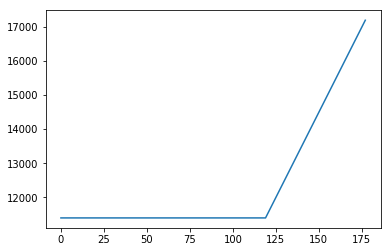

In [65]:
plt.plot(p1.total_payoff()[0],p1.total_payoff()[1])

In [158]:
root = Tk()

In [159]:
#creating label
mylabel = Label(root, text = "Option Payoff Diagram")
mylabel2 = Label(root,text = "Input positions below")
slabel = Label(root,text="Underlying")
elabel = Label(root,text="Call/Put")
nlabel = Label(root,text="Long/Short")
plabel= Label(root,text="Maturity")
p2label= Label(root,text="Quantity")
p3label= Label(root,text="Strike")
s  = Entry(root)
e  = Entry(root)
n  = Entry(root)
p = Entry(root)
p2 = Entry(root)
p3 = Entry(root)
mylabel.grid(row=0, column = 1)
mylabel2.grid(row = 1, column =1)
s.grid(row =2, column = 1)
e.grid(row=3, column = 1)
n.grid(row=4, column = 1)
p.grid(row=2, column = 3)
p2.grid(row=3, column= 3)
p3.grid(row=4, column = 3)
slabel.grid(row=2,column=0)
elabel.grid(row =3, column =0)
nlabel.grid(row=4,column=0)
plabel.grid(row=2,column=2)
p2label.grid(row=3,column=2)
p3label.grid(row=4, column=2)

In [160]:
p1 = Portfolio()
def myClick():
    position = Option(float(p3.get()),str(e.get()),str(s.get()),int(p2.get()),str(n.get()),str(p.get()))
    p1.add_position(position)
def myClick1():
    position = Stock(str(s.get()),int(p2.get()),str(n.get()))
    p1.add_position(position)

In [161]:
def myClick2():
    p1.get_data()
    
    f = Figure(figsize=(4,4), dpi=100)
    a = f.add_subplot(111)
    a.plot(p1.total_payoff()[0],p1.total_payoff()[1])
    
    canvas = FigureCanvasTkAgg(f, master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row = 7, column = 1)
def myClear():
    p1.calls = []
    p1.puts = []
    p1.long = []
    p1.short = []
    p1.data = ""

In [162]:
myButton = Button(root, text="Add Option", command = myClick)
myButton.grid(row = 5, column = 1)
myButton1 = Button(root, text="Add Stock", command = myClick1)
myButton1.grid(row = 5, column = 2)
myButton2 = Button(root, text="Draw", command = myClick2)
myButton2.grid(row = 5, column = 3)
myButton3 = Button(root,text = "CLEAR ALL DATA", command = myClear)
myButton3.grid(row = 6, column = 1)

In [163]:
root.mainloop()